## Run with single command

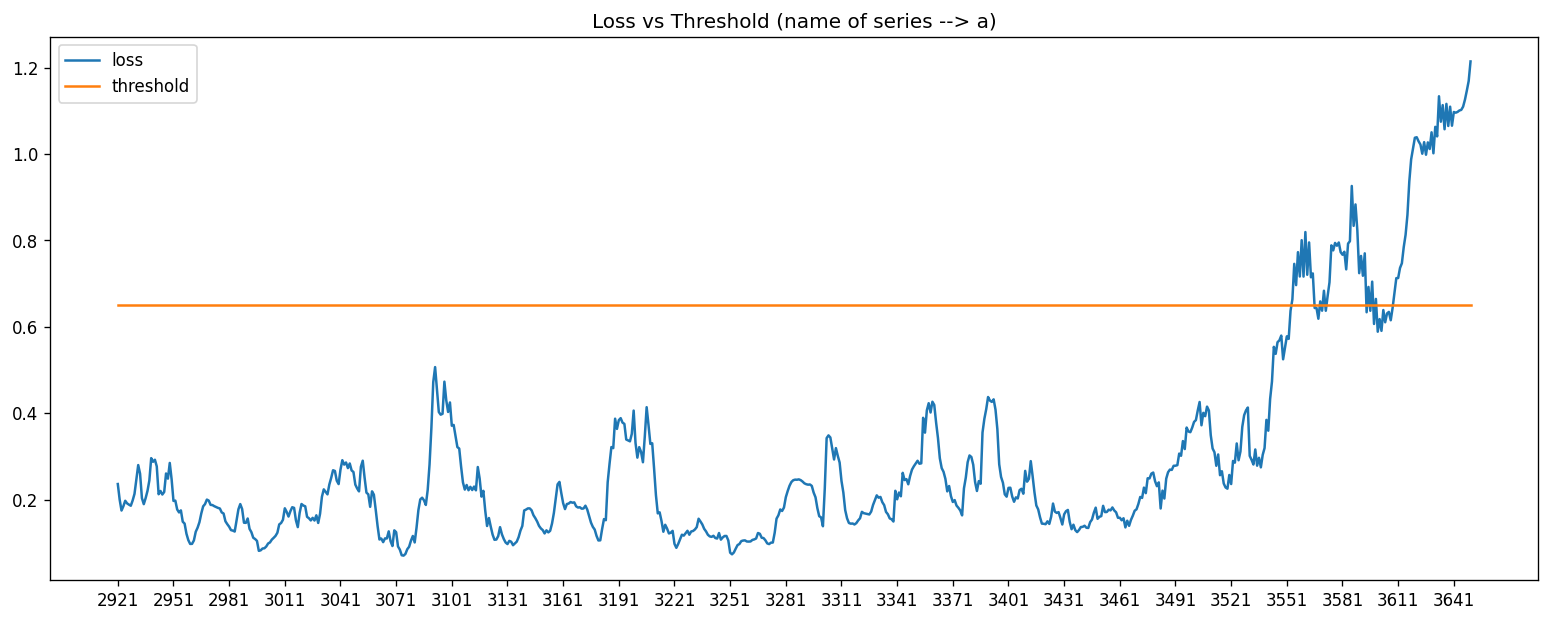

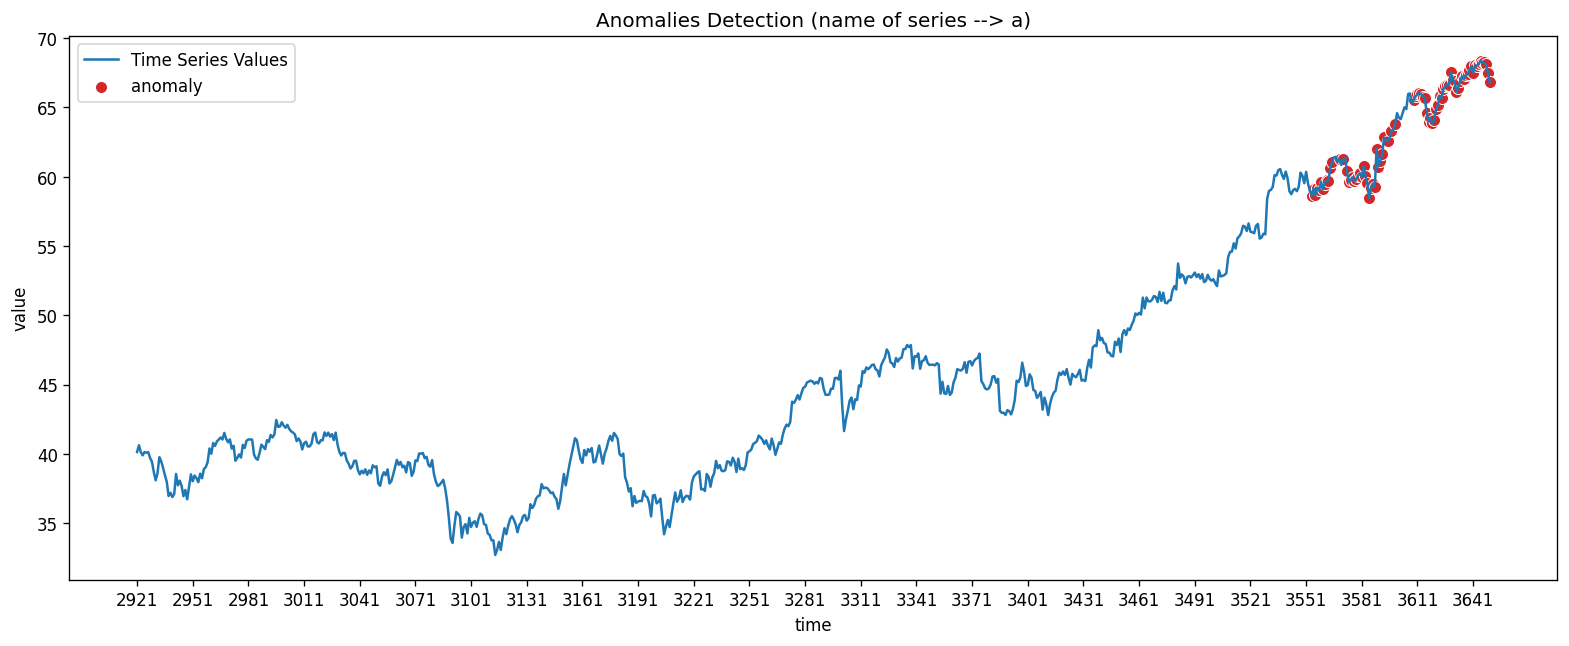

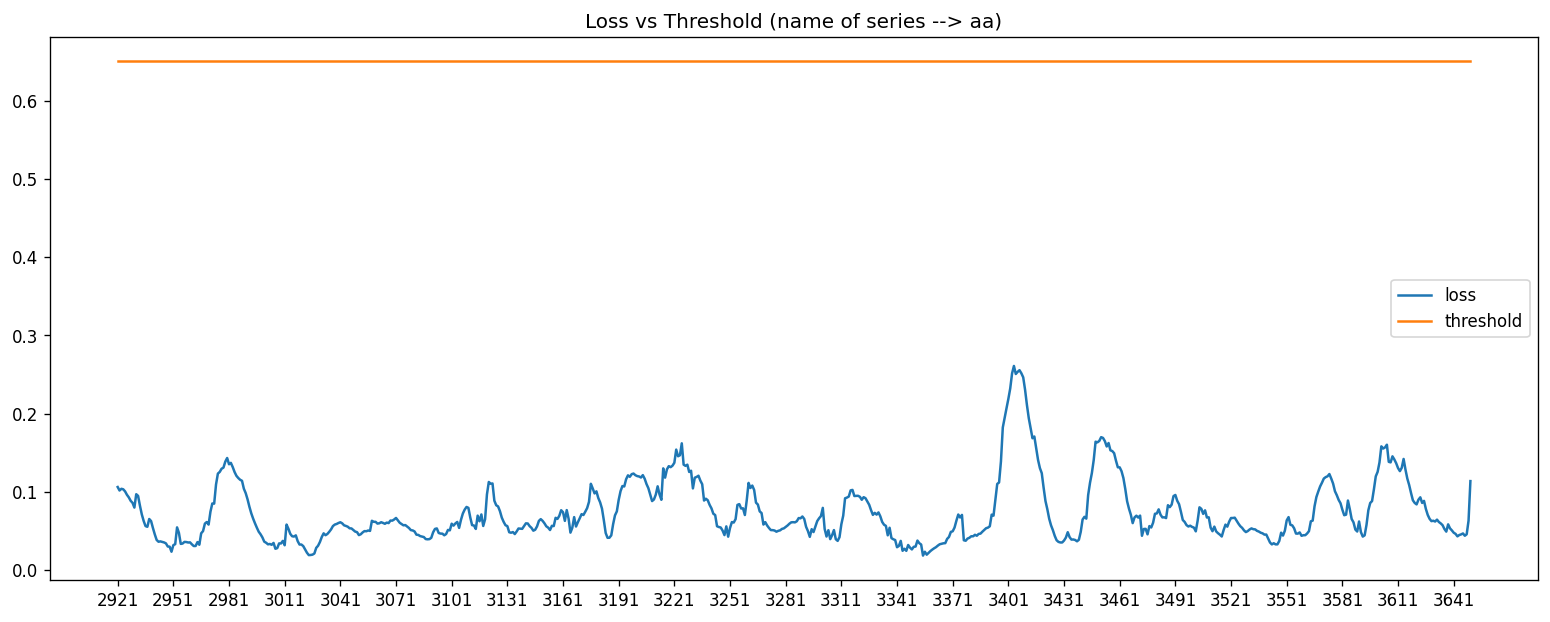

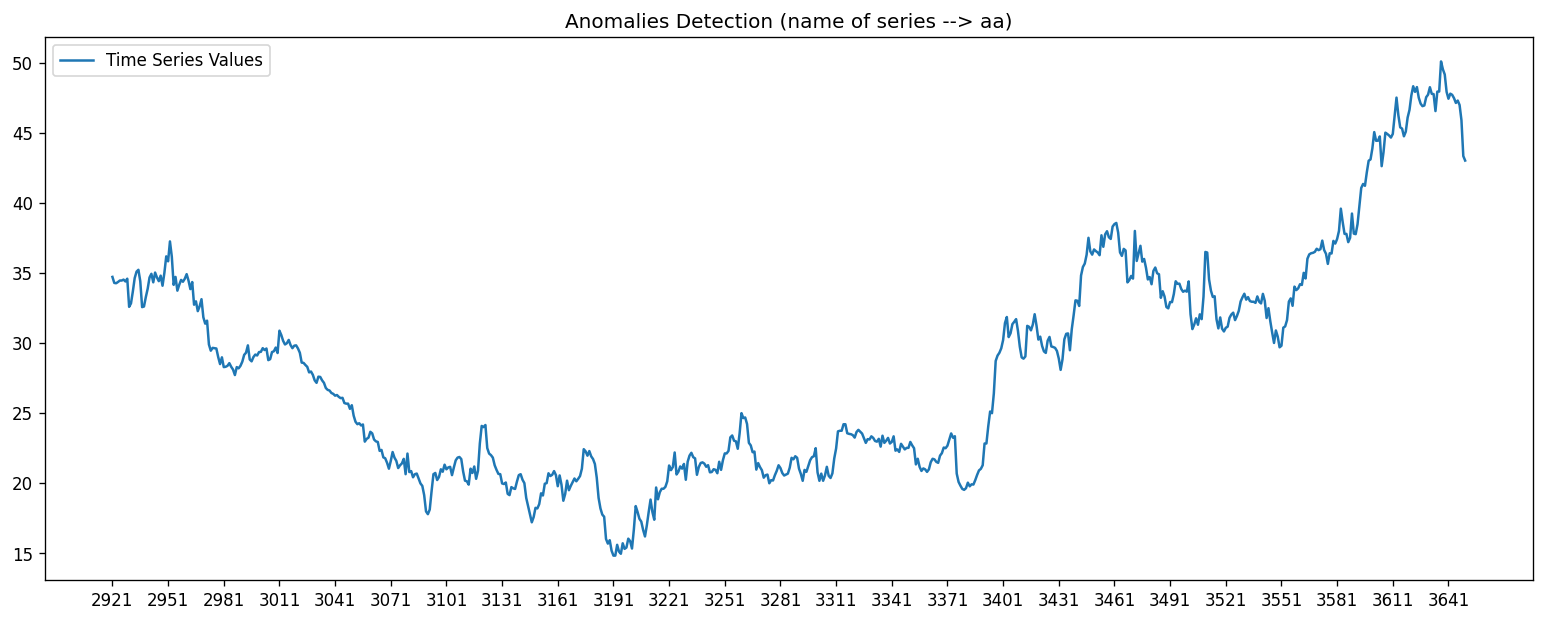

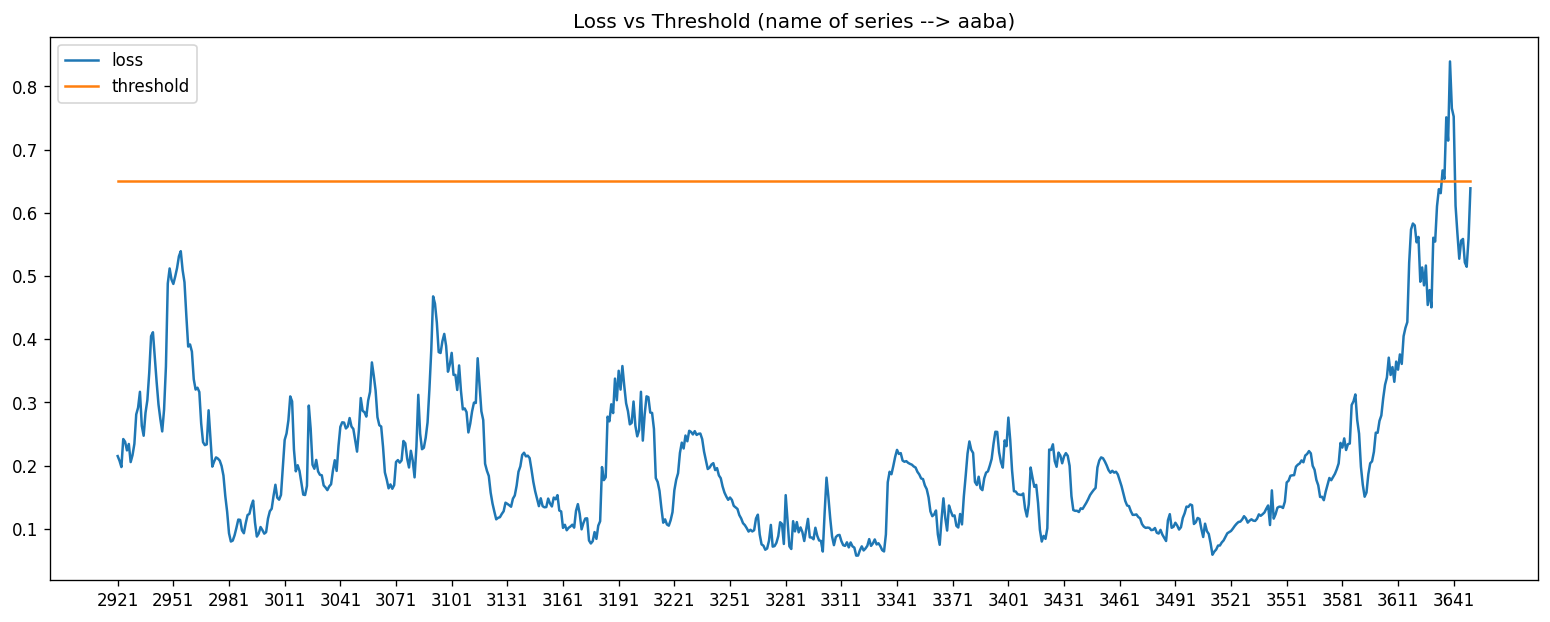

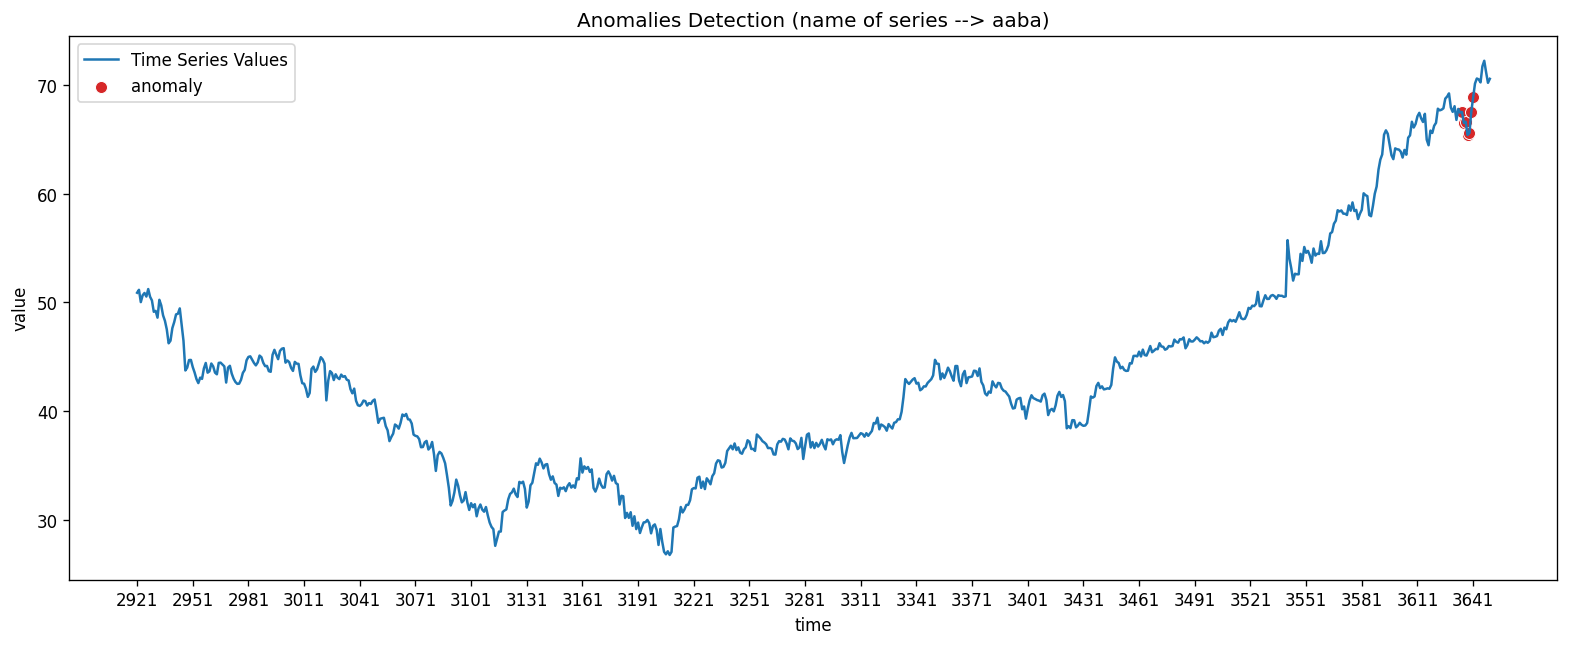

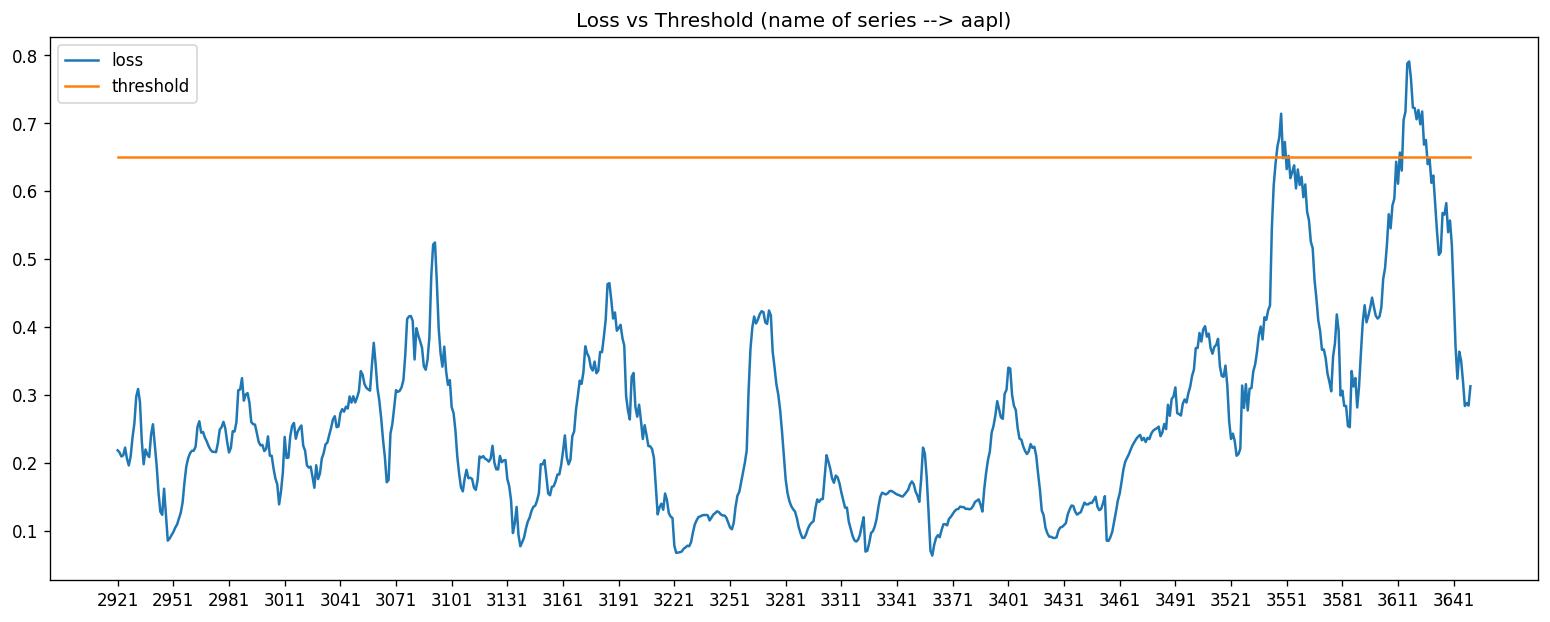

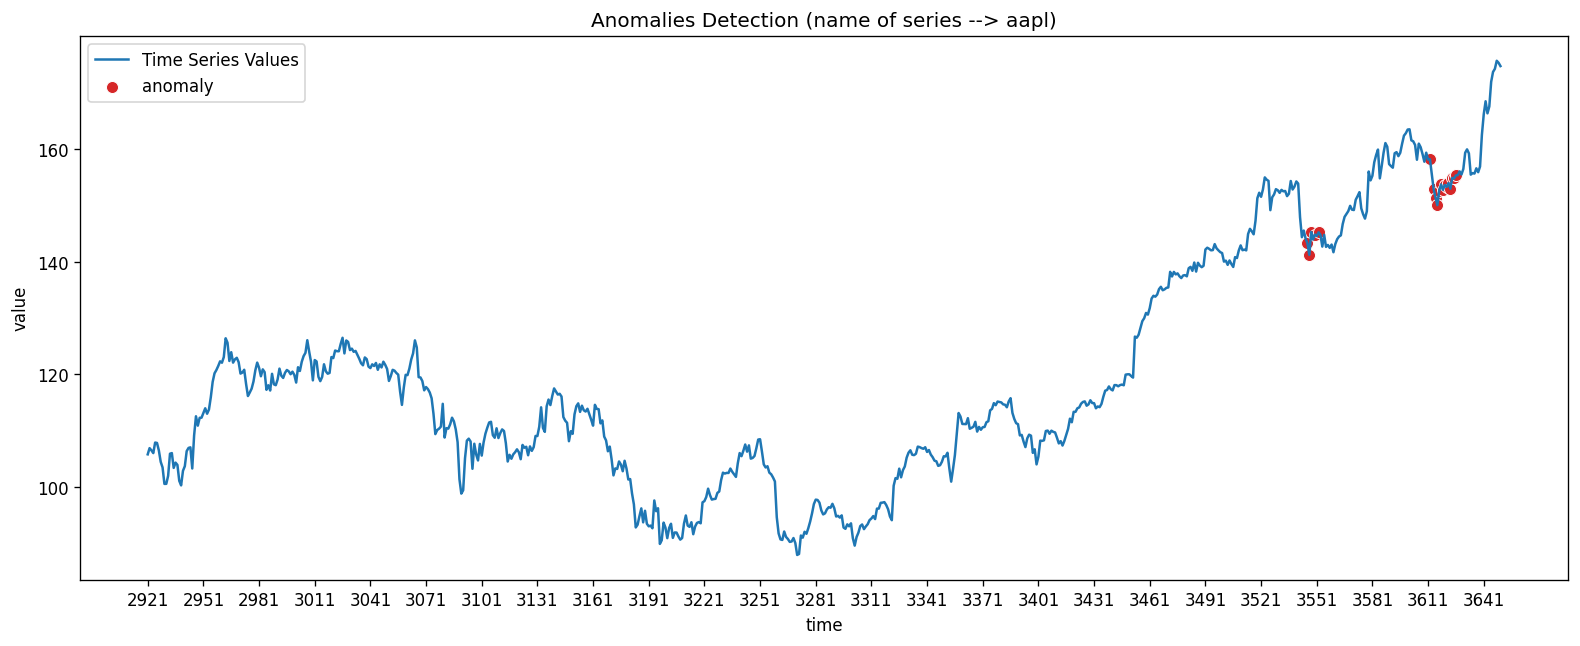

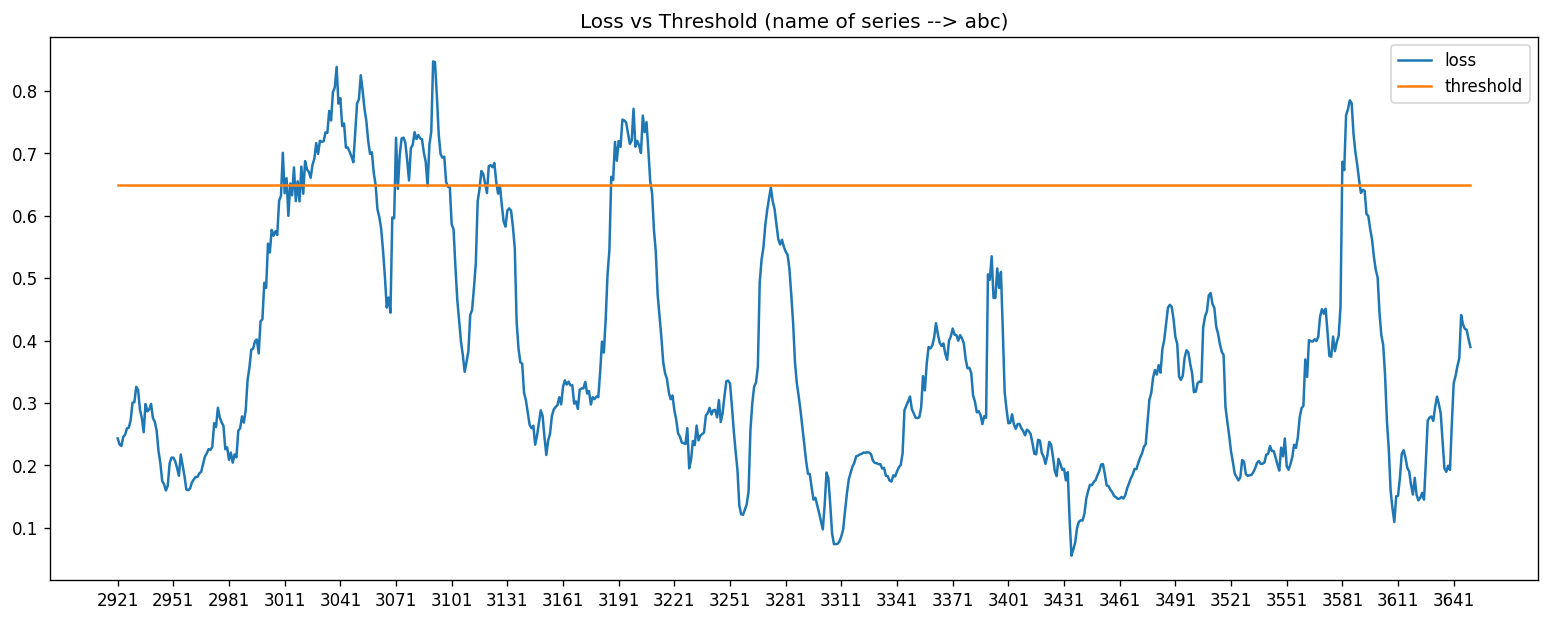

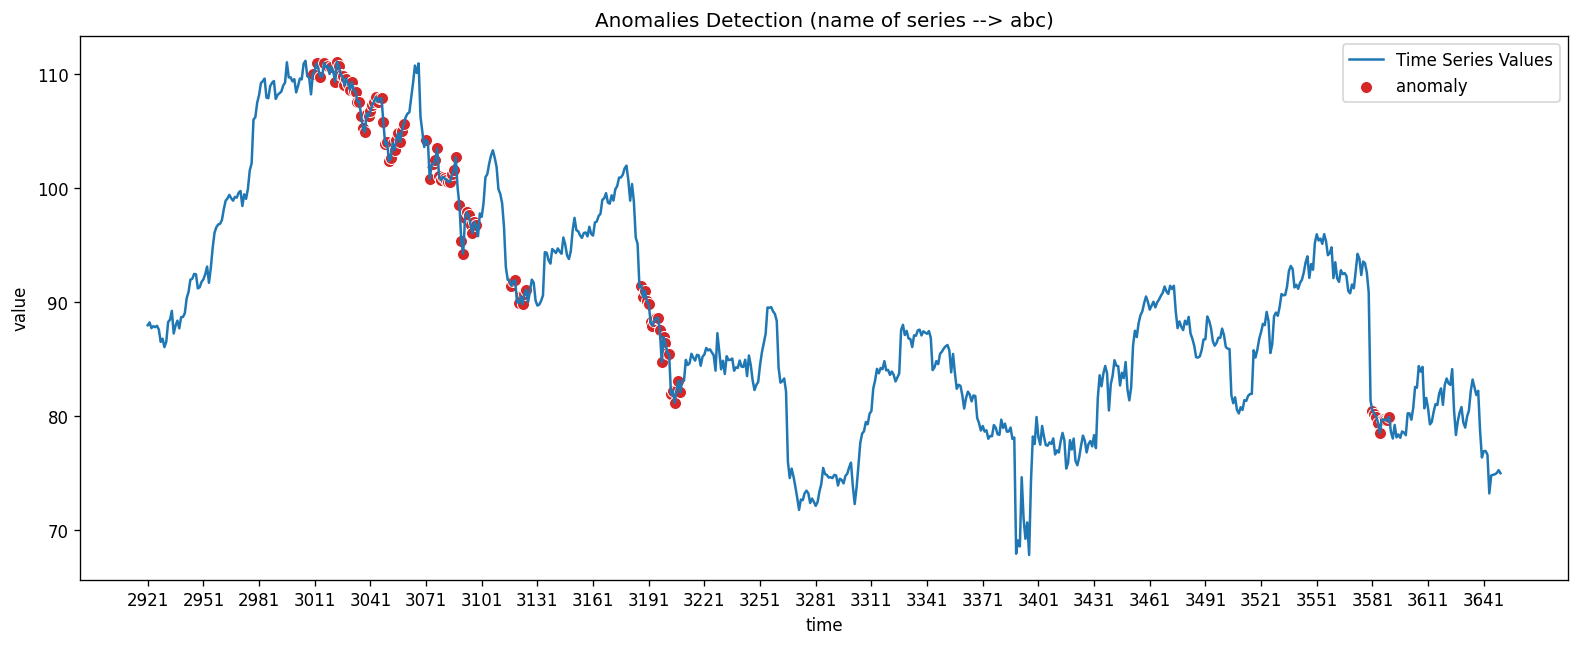

In [1]:
%run "/content/detect.py" -d ./content/data/nasdaq2007_17.csv -n 5 -mae 0.65

## detect_utils.py

In [ ]:
""" file : detect_utils.py """
""" helper functions for detect.py main"""

""" general imports """
import sys
import string

""" imports for plots, dataframes, numpy """
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

""" keras neural network imports """
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import *
from keras.callbacks import EarlyStopping

""" sklearn imports """
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split


def config_model(input_size):
    """ configure and return RNN-LSTM autoencoder model to be trained """
    model = Sequential()
    """ Encoder """
    # Adding a first encoding LSTM layer
    model.add(LSTM(units = 64, input_shape = (input_size, 1)))
    # Dropout layer to avoid overfitting
    model.add(Dropout(rate = 0.2))
    # RepeatVector layer repeats the input vector n times, provides output as input for decoder
    model.add(RepeatVector(n = input_size))
    """ Decoder """
    # Adding a first decoding LSTM layer
    model.add(LSTM(units = 64, return_sequences = True))
    # Dropout layer to avoid overfitting
    model.add(Dropout(0.2))
    # Adding the output layer
    model.add(TimeDistributed(Dense(units = 1)))
    # Compiling the RNN by determinng optimizer and loss function
    model.compile(optimizer = 'adam', loss = 'mae')
    return model


def plot_loss(history):
    """ plot the train loss vs test loss learning curve for given training history """
    plt.figure(figsize=(16, 6), dpi=120)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model train vs test loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

def plot_threshold(time_points, loss, threshold, window, series_name):
    """ plot loss vs threshold graph for given series """
    plt.figure(figsize=(16, 6), dpi=120)
    plt.plot(time_points, loss, label='loss')
    plt.plot(time_points, threshold, label='threshold')
    plt.xticks(np.arange(time_points[0], time_points[-1], window))
    plt.title("Loss vs Threshold (name of series --> %s)" % (series_name))
    plt.legend()
    plt.show()

def plot_anomalies(time_points, series_values, anomalies_points, anomalies_values, window, series_name):
    """ plots the anomalies found, along with the original time series """
    plt.figure(figsize=(16, 6), dpi=120)
    plt.plot(time_points, series_values, label='Time Series Values')
    sns.scatterplot(x=anomalies_points, y=anomalies_values, color=sns.color_palette()[3], s=52, label='anomaly')
    plt.xticks(np.arange(time_points[0], time_points[-1], window))
    plt.title("Anomalies Detection (name of series --> %s)" % (series_name))
    plt.legend()
    plt.show()


def create_dataset(input_set, num_of_series, num_of_steps, w):
    """ creates the x_set, y_set (x_train / y_train or x_test / y_test ) out of the input_set
        input_set : 2D array -> columns are different time series, rows are time series values across time
        num_of_series : number of series in input_set
        num_of_steps  : number of steps = size of x_set and y_set
        w : window of sampling """

    # x_set will contain windows of w consecutive values for all time series of input_set
    x_set = []
    # y_set will contain the next value of corresponding time series for each of the windows of x_set
    y_set = []

    for series_index in range(num_of_series):
        for i in range(w, num_of_steps + w):
            # append next window of w consecutive values of time series in x_set
            x_set.append(input_set[i-w:i, series_index])
            # append next value of time series outside current window in y_set
            y_set.append(input_set[i, series_index])

    # convert to np arrays
    x_set, y_set = np.array(x_set), np.array(y_set)
    # reshape x_set to a tensor of size (#time_series * num_of_steps, window, 1)
    x_set = np.reshape(x_set, (x_set.shape[0], x_set.shape[1], 1))

    return x_set, y_set


def execute(series_values, series_names, w, n, threshold, load_trained_model):
    """ function where main work gets done
        series_values : 2D array -> columns are different time series, rows are time series values across time
        series_names  : 1D array -> rows have the names of the time series
        w : window of sampling
        n : number of series to make predictions for
        threshold : for anomaly detection
        load_trained_model : if True, a pre trained model will be loaded, otherwise a new model will be trained """

    # train test split 80-20 rule (the first 80% of time series values will be used for the training, rest 20% for testing)
    train_set_size = math.floor((series_values.shape[0])*0.8)

    # save train set after split
    train_set = series_values[:train_set_size]

    # save test set after split
    test_set = series_values[train_set_size:]

    # scale train set per series/column using standardization
    scaler = StandardScaler()
    scaled_train_set = scaler.fit_transform(train_set)

    num_of_series = series_values.shape[1]

    # get x_train, y_train
    x_train, y_train = create_dataset(scaled_train_set, num_of_series, train_set.shape[0] - w, w)

    if load_trained_model is False:
        # configure new RNN-LSTM model
        model = config_model(x_train.shape[1])
    else:
        # load pre trained RNN-LSTM model
        model = load_model('./content/models/detect/autoencoder.h5')

    # getting all the values of all selected time series starting from the last window before the test set
    inputs = series_values[series_values.shape[0] - test_set.shape[0] - w:]
    # scale using standardization based on train set
    inputs = scaler.transform(inputs)

    # get x_test, y_test
    x_test, y_test = create_dataset(inputs, num_of_series, test_set.shape[0], w)

    # if load_trained_model option was not given, train new model
    if load_trained_model is False:
        # train model by fitting it to the training set
        history = model.fit(x_train, y_train, epochs = 10, batch_size = 32, validation_data=(x_test, y_test), verbose=1, shuffle=False)
        # plot the train loss vs test loss learning curve for given training history
        plot_loss(history)
        # save trained model for future use
        model.save('./content/models/detect/autoencoder.h5')

    # time axis
    time_points = [index + 1 for index in range(train_set.shape[0], series_values.shape[0])]

    # for each of the selected time series make the anomalies plot
    for series_index in range(n):
        # get name for current time series
        series_name = series_names[series_index, 0]

        # get series test set for current time series
        series_test_set = test_set[:, series_index:series_index+1]

        # get x_train for current time series
        #x_train_series = x_train[train_set.shape[0] * series_index : train_set.shape[0] * (series_index+1), :, :]

        # get predictions of model on x_train for current time series (using trained autoencoder)
        #x_pred_train = model.predict(x_train_series)

        #calculate mean absolute error for prediction of current time series on train set
        #train_mae_loss = np.mean(np.abs(x_pred_train - x_train_series), axis=1)
        # loss above 90% of max train loss will be considered anomaly for train set
        #threshold = train_mae_loss.max() * 0.9

        # get x_test for current time series
        x_test_series = x_test[test_set.shape[0] * series_index : test_set.shape[0] * (series_index+1), :, :]

        # get predictions of model on x_test for current time series (using trained autoencoder)
        x_pred_series = model.predict(x_test_series)

        # calculate mean absolute error for prediction of current time series on test set
        test_mae_loss = np.mean(np.abs(x_pred_series - x_test_series), axis=1)

        # convert test set of current series to a dataframe for convenience
        test_df = pd.DataFrame(series_test_set, columns = ['value'])
        # add useful columns
        test_df['time'] = time_points
        test_df['loss'] = test_mae_loss
        test_df['threshold'] = threshold
        test_df['anomaly'] = test_df.loss > test_df.threshold

        # plot loss vs threshold graph for current series
        plot_threshold(time_points, test_df.loss, test_df.threshold, w, series_name)
        # find anomalies in predicted series
        anomalies = test_df[test_df.anomaly == True]
        # plot the anomalies found
        plot_anomalies(time_points, test_df.value, anomalies.time, anomalies.value, w, series_name)


## detect.py

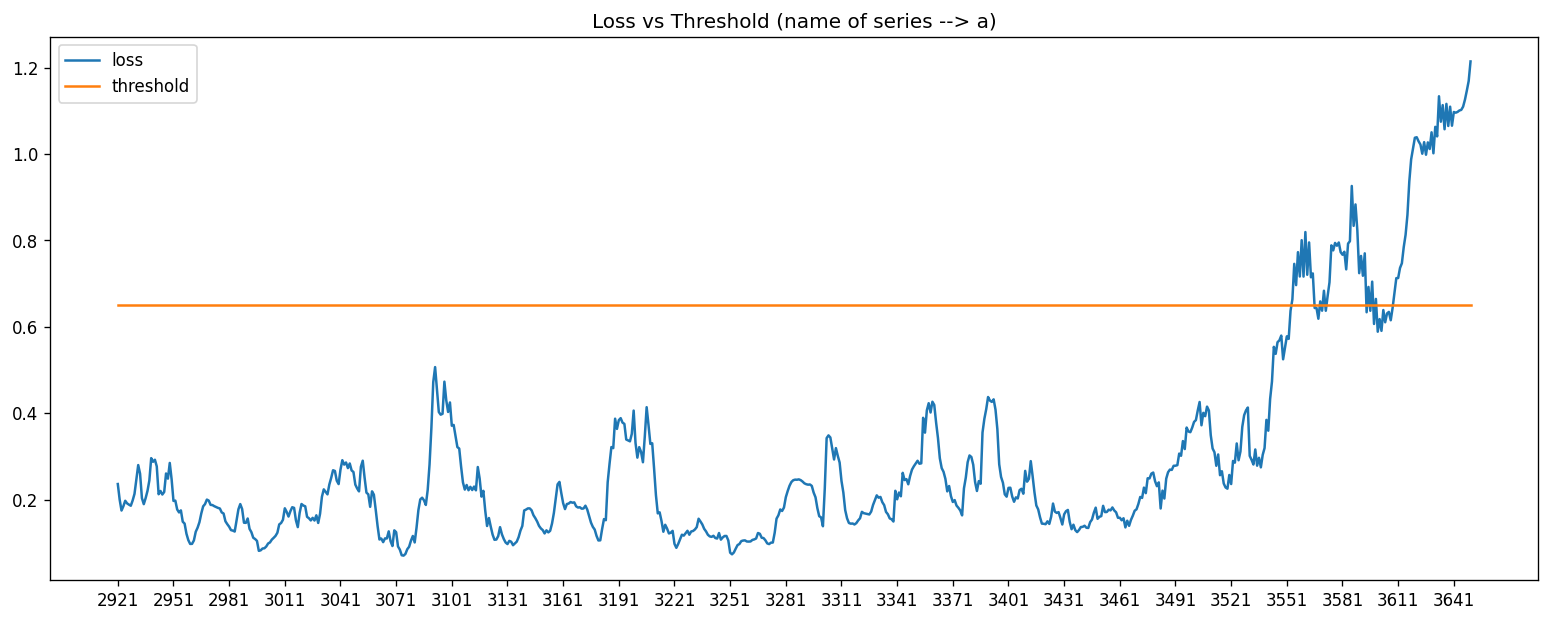

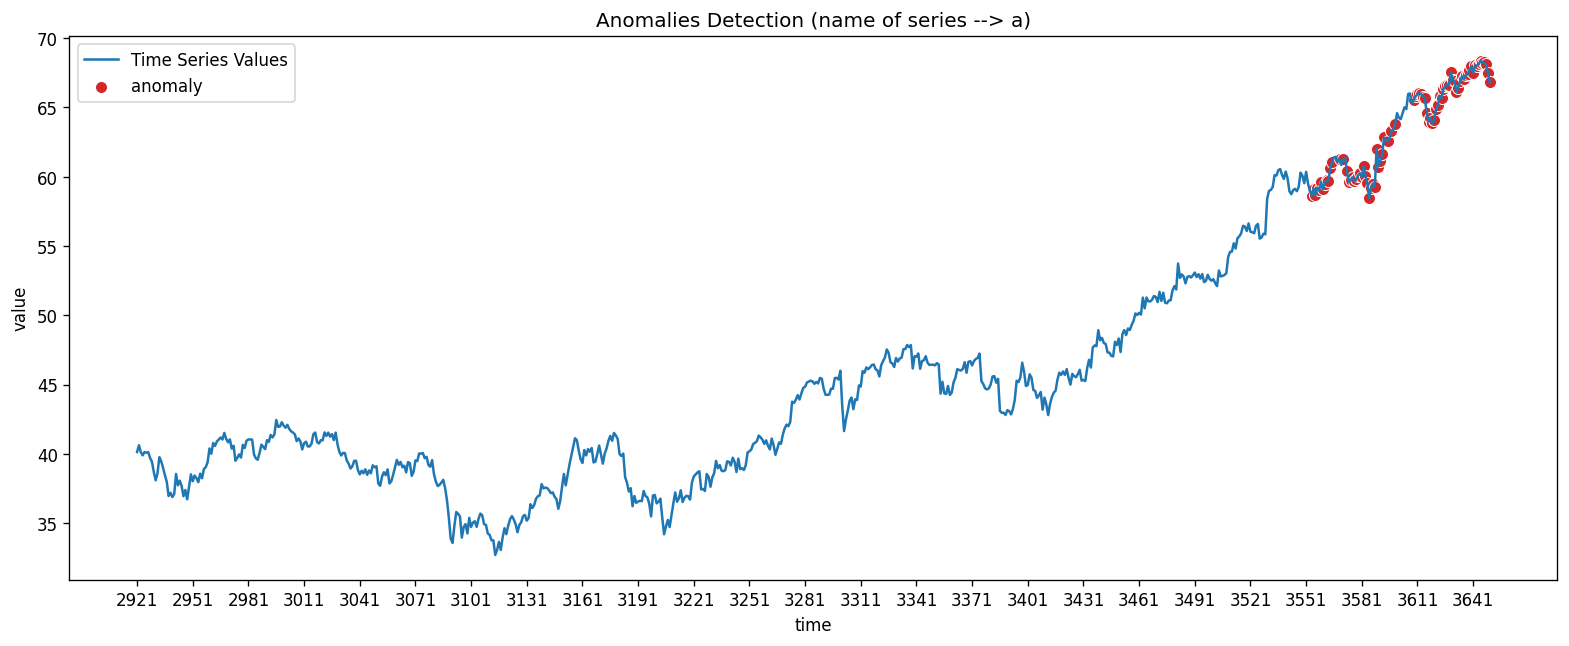

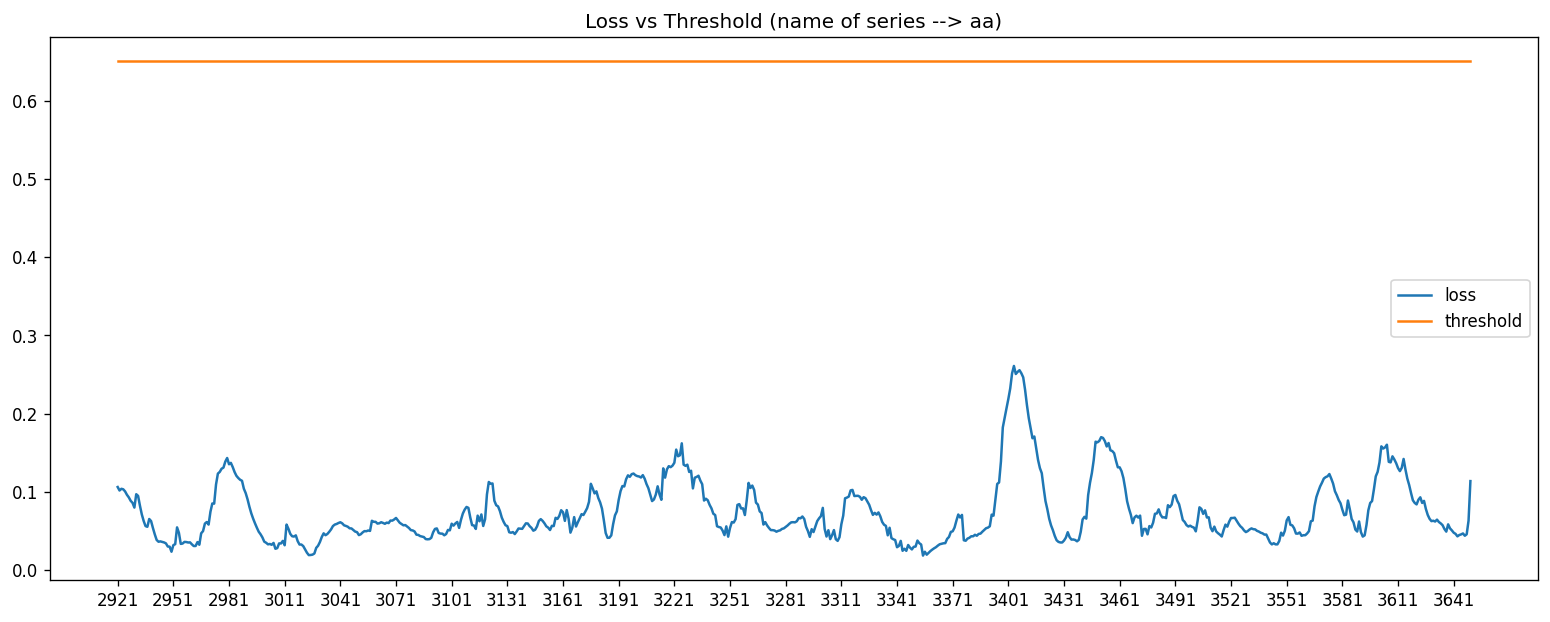

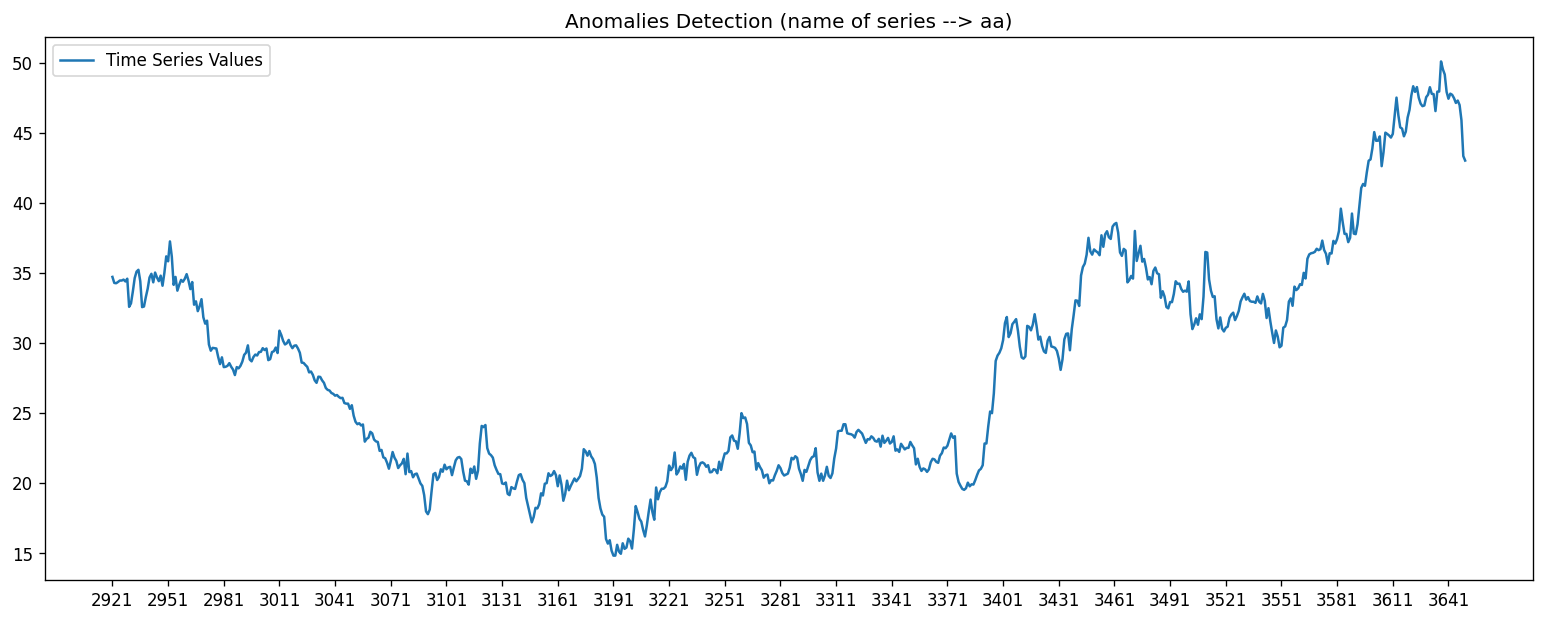

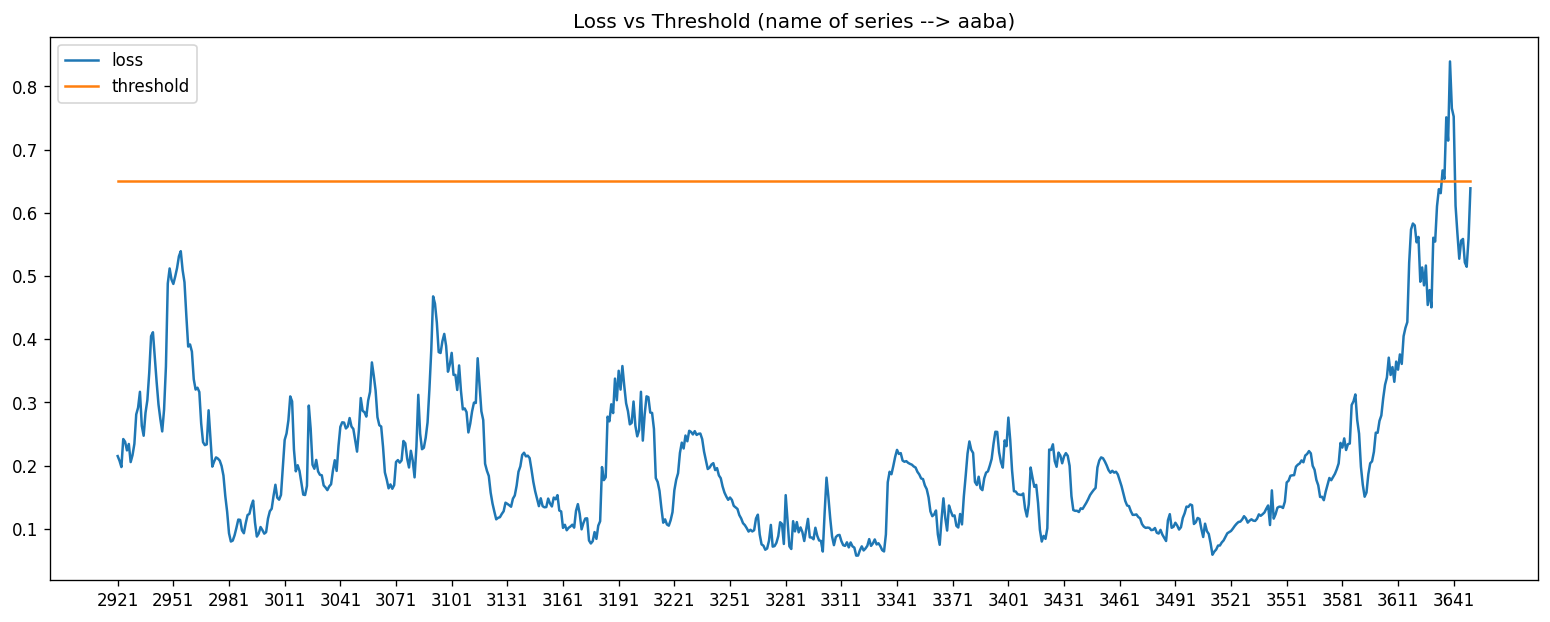

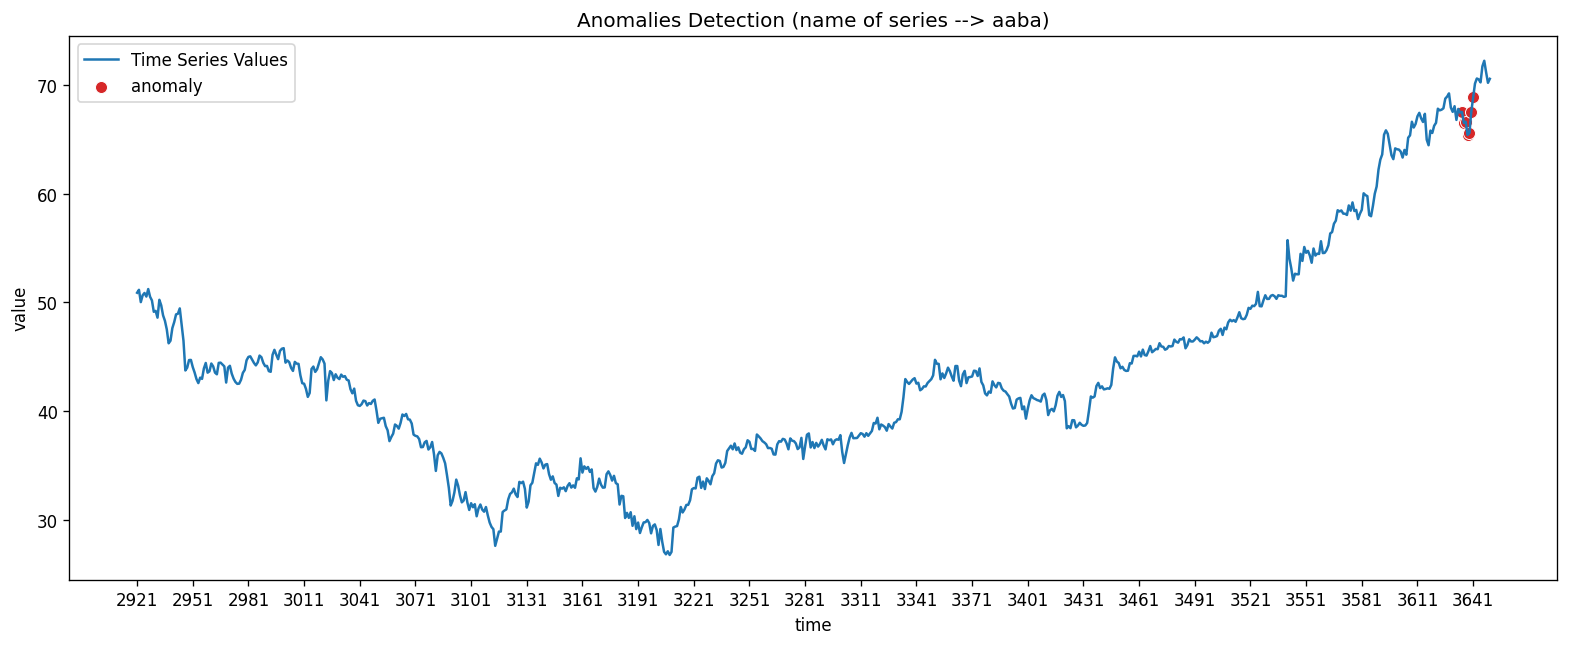

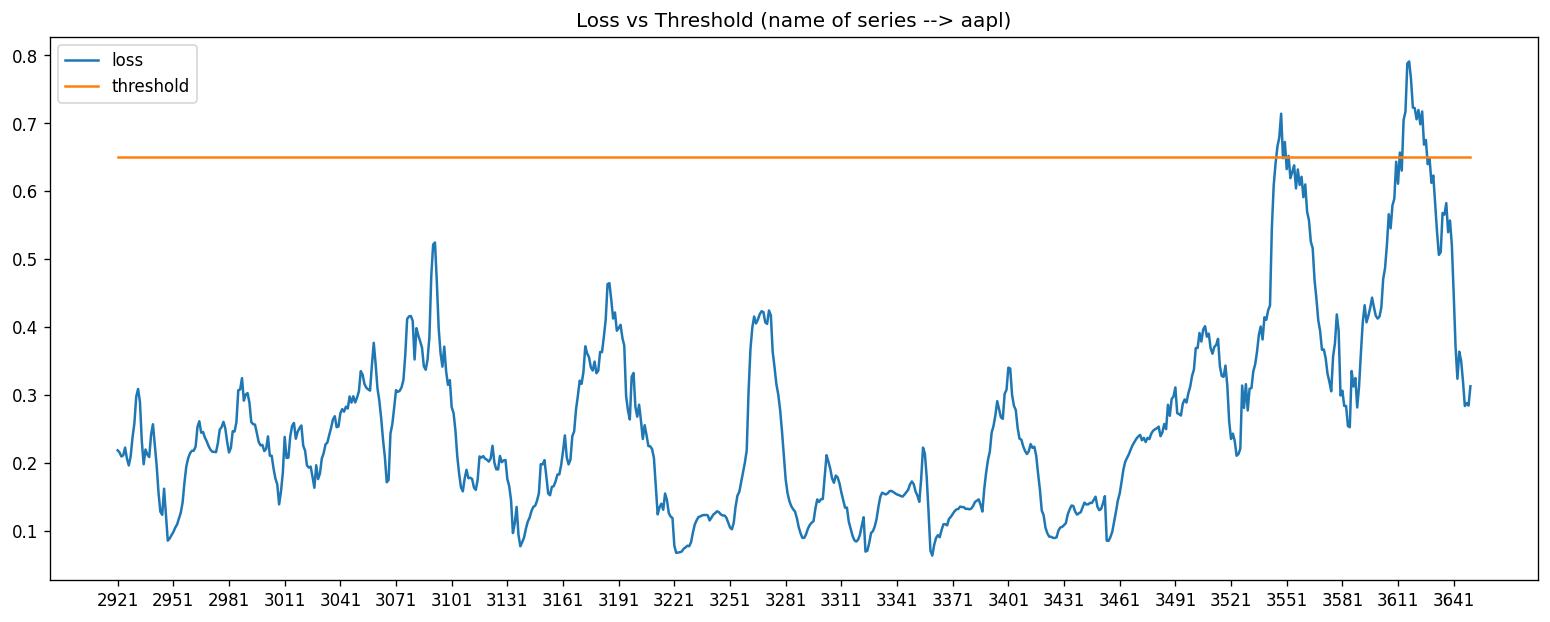

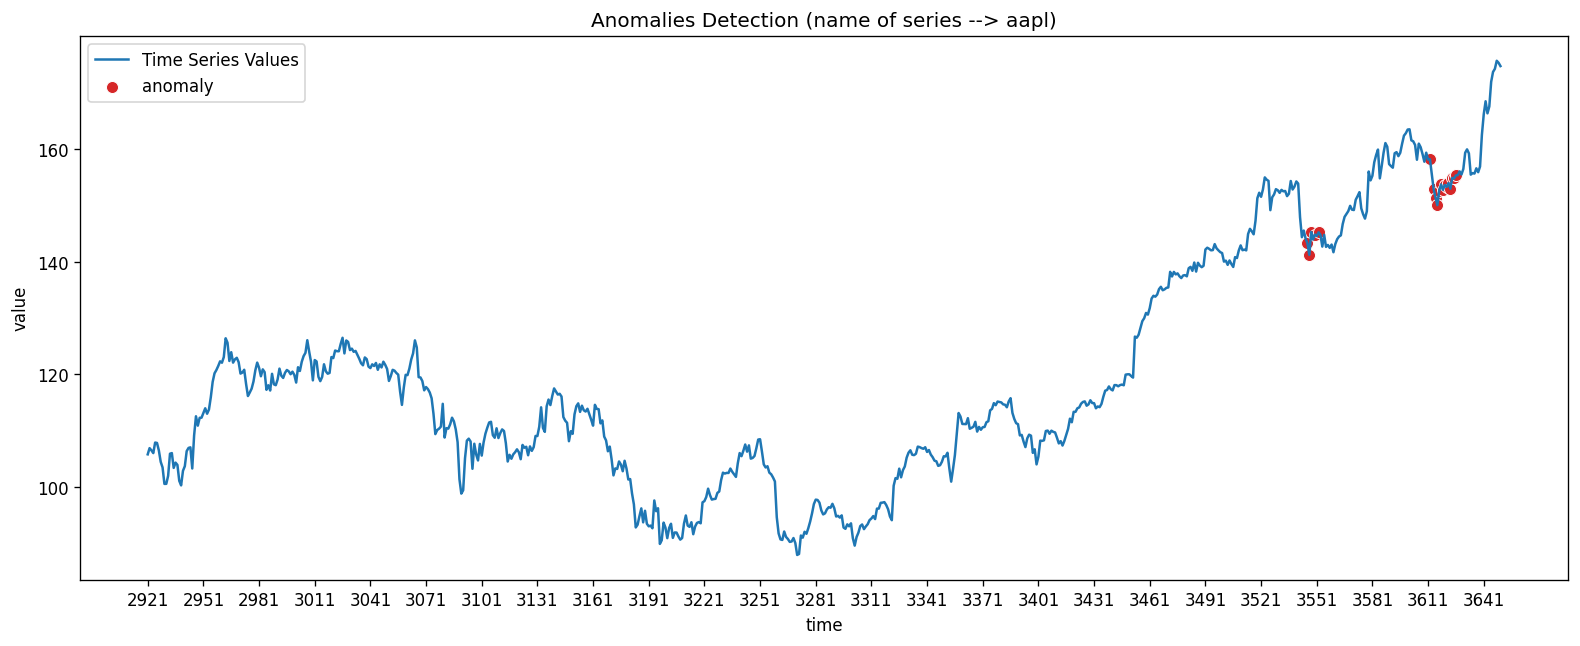

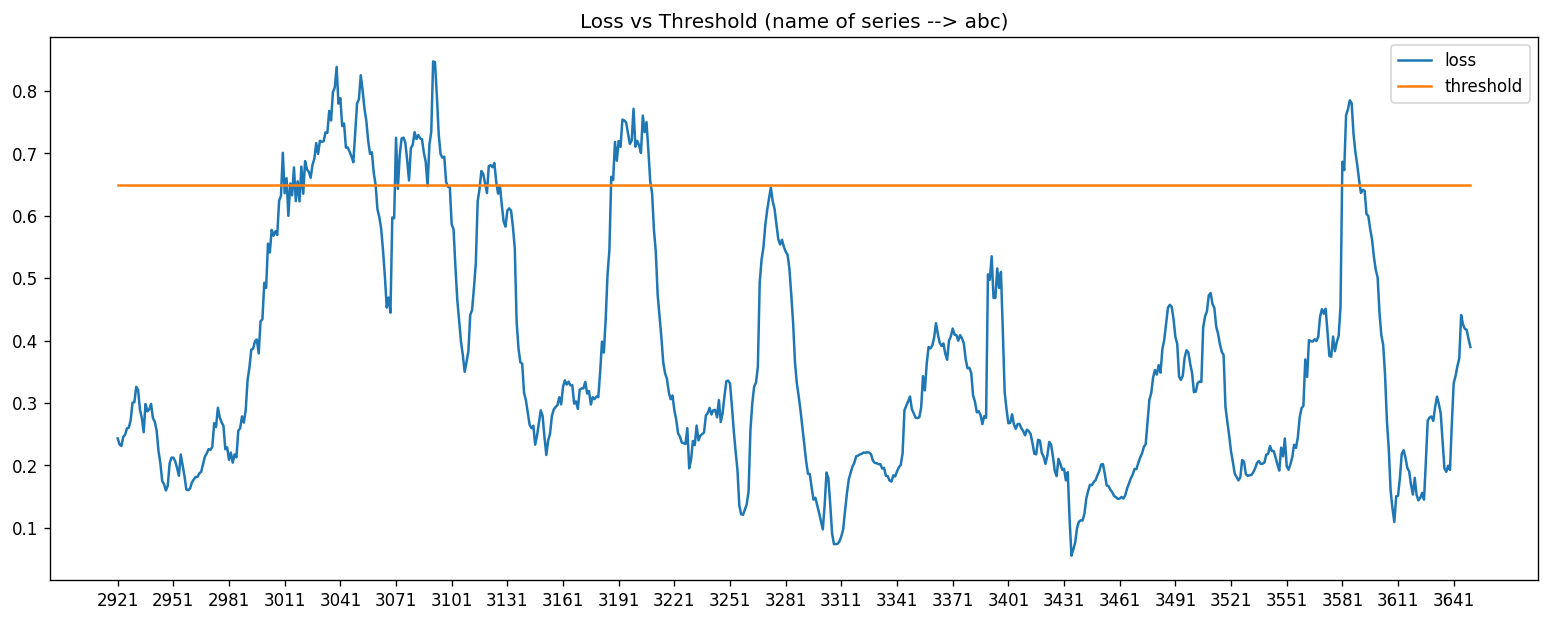

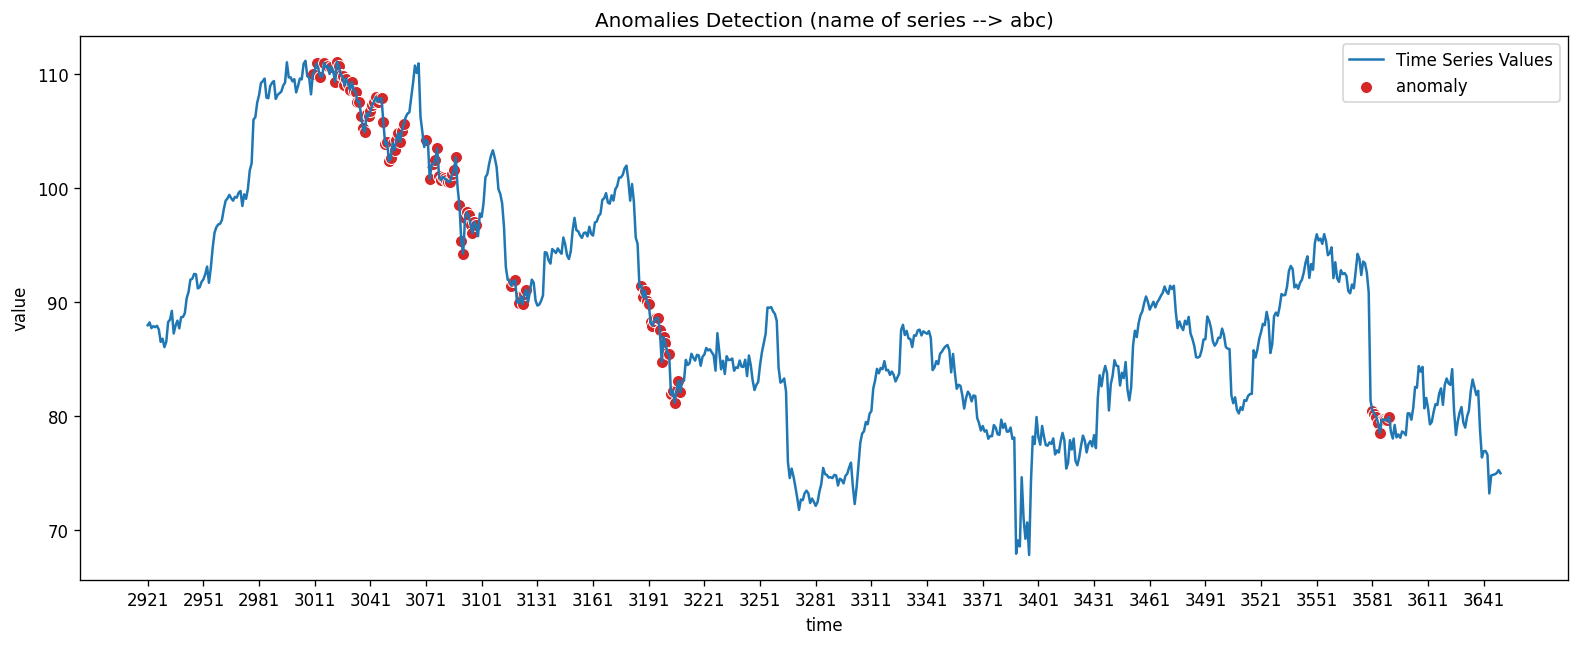

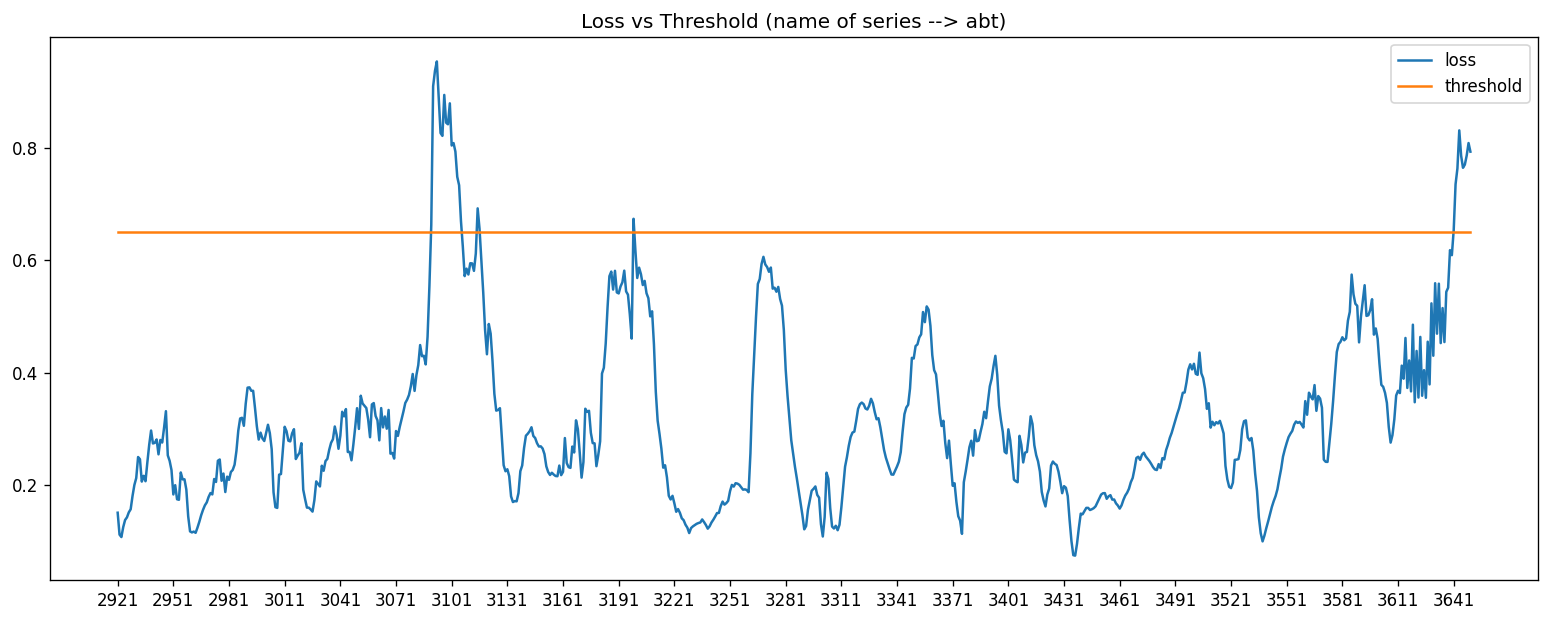

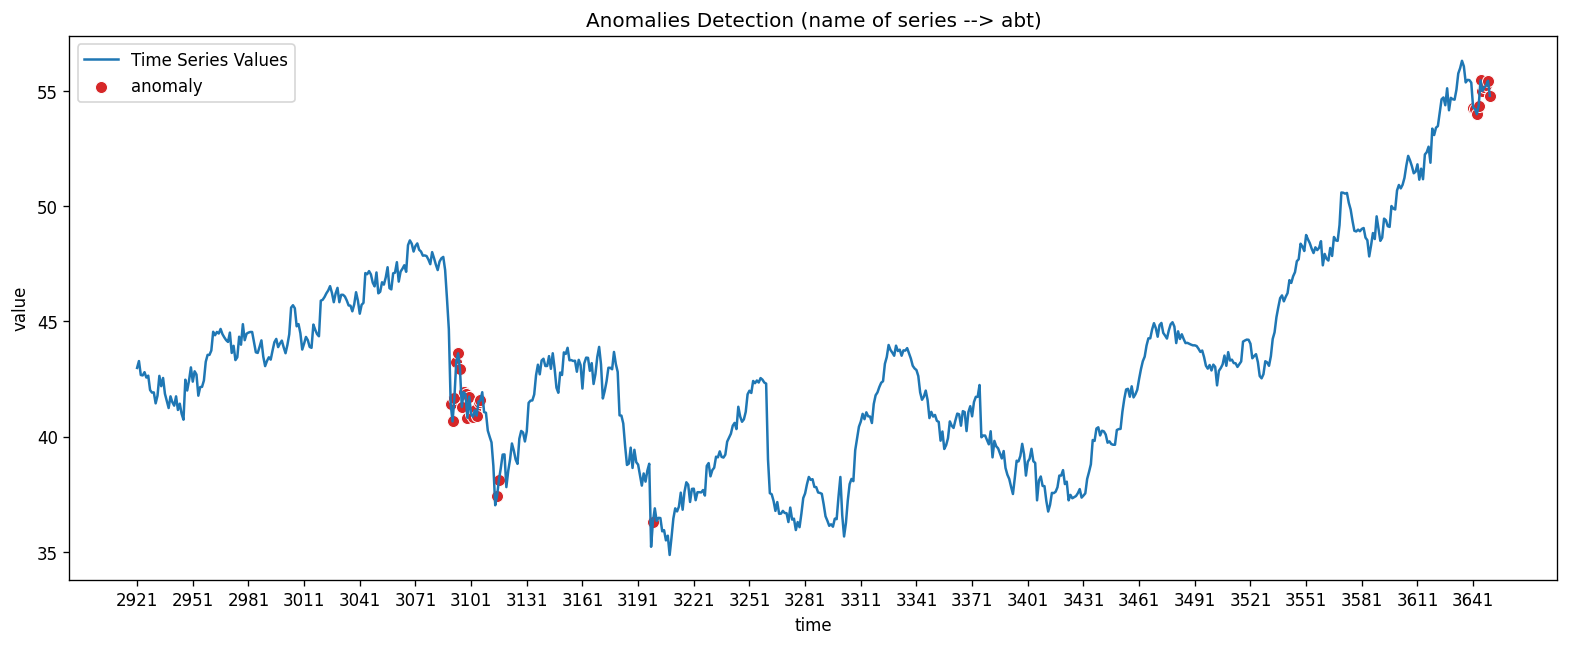

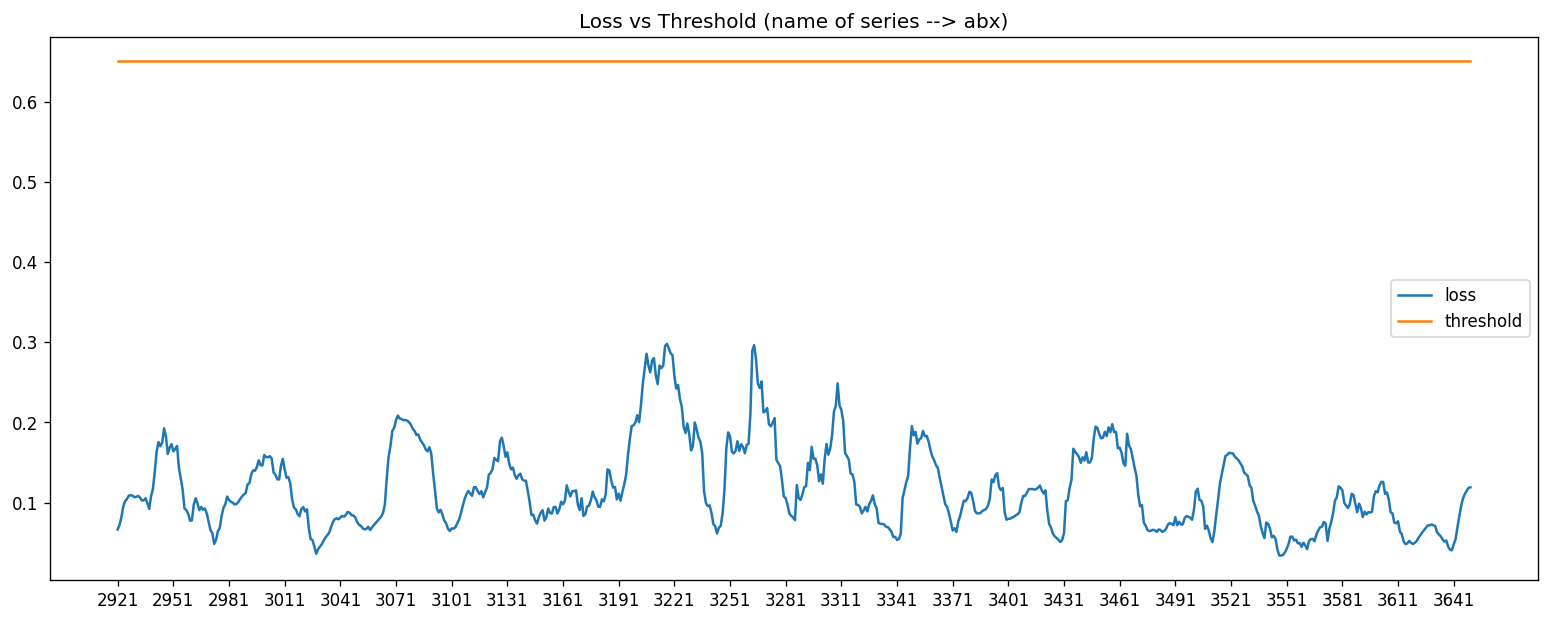

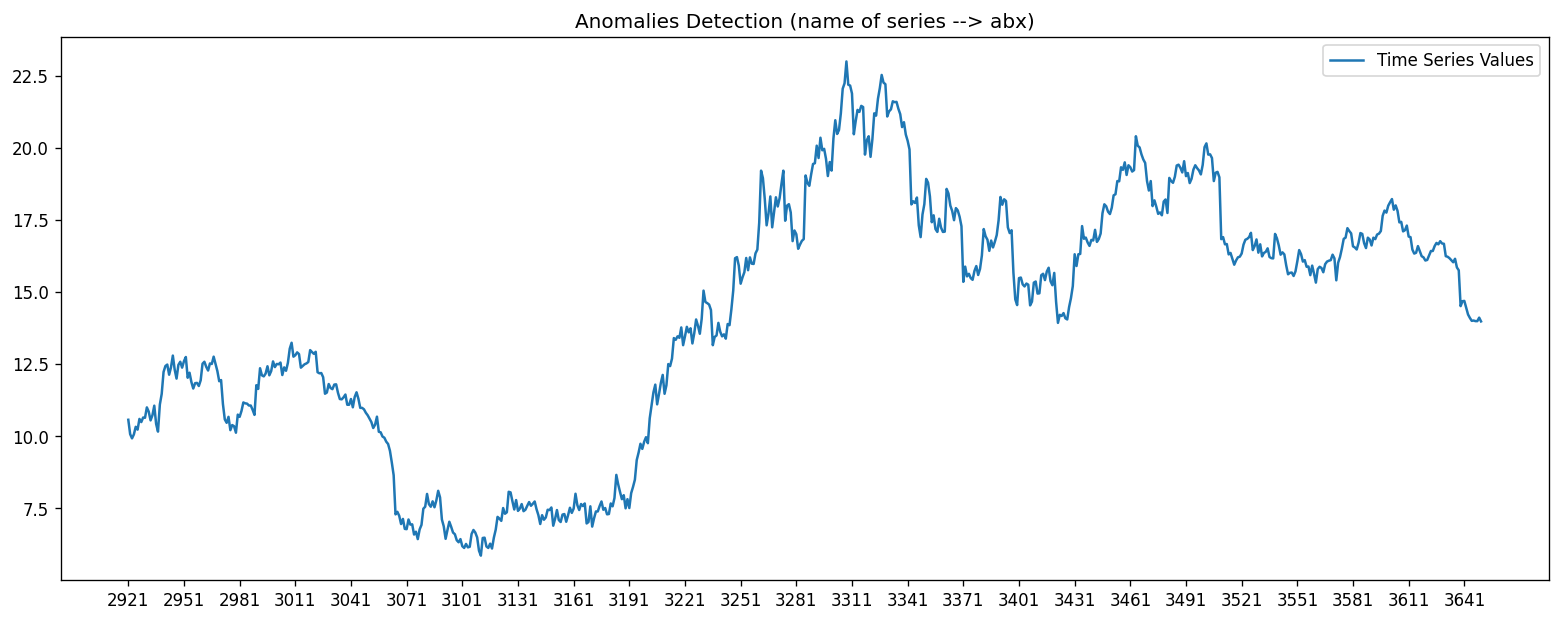

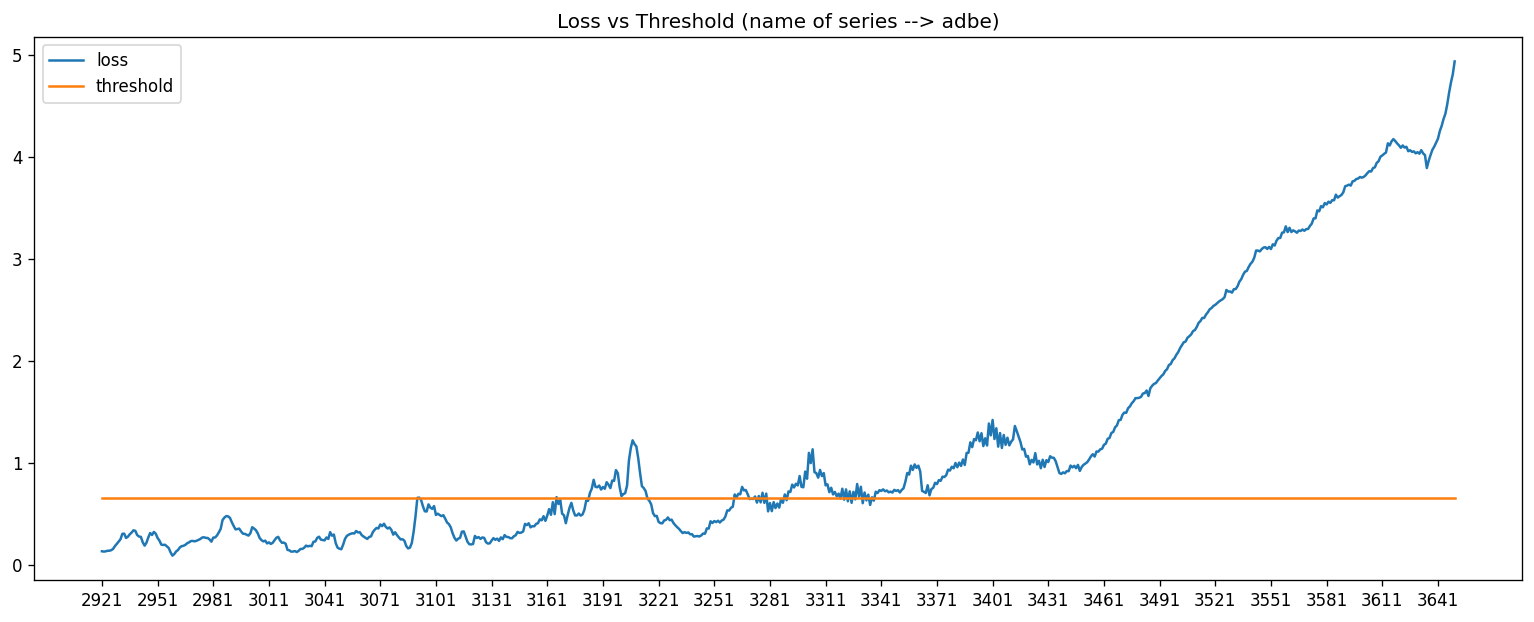

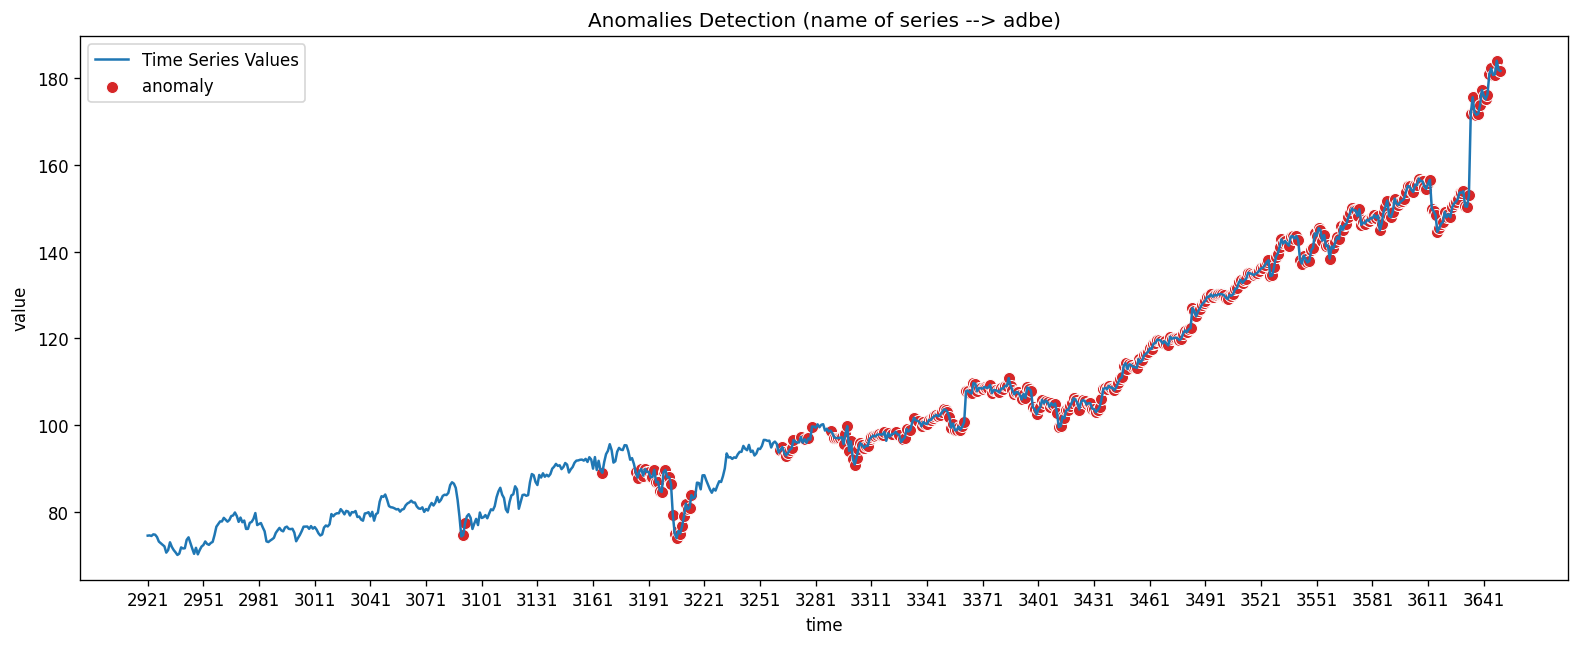

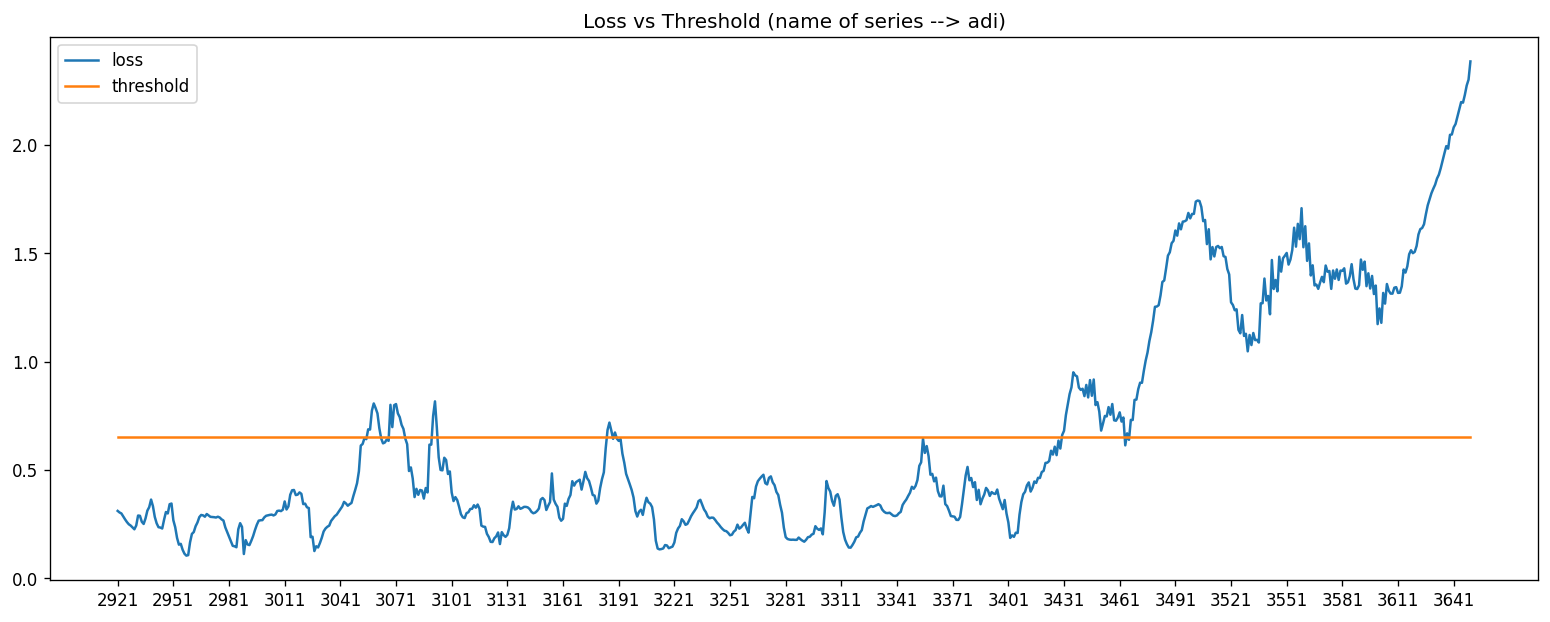

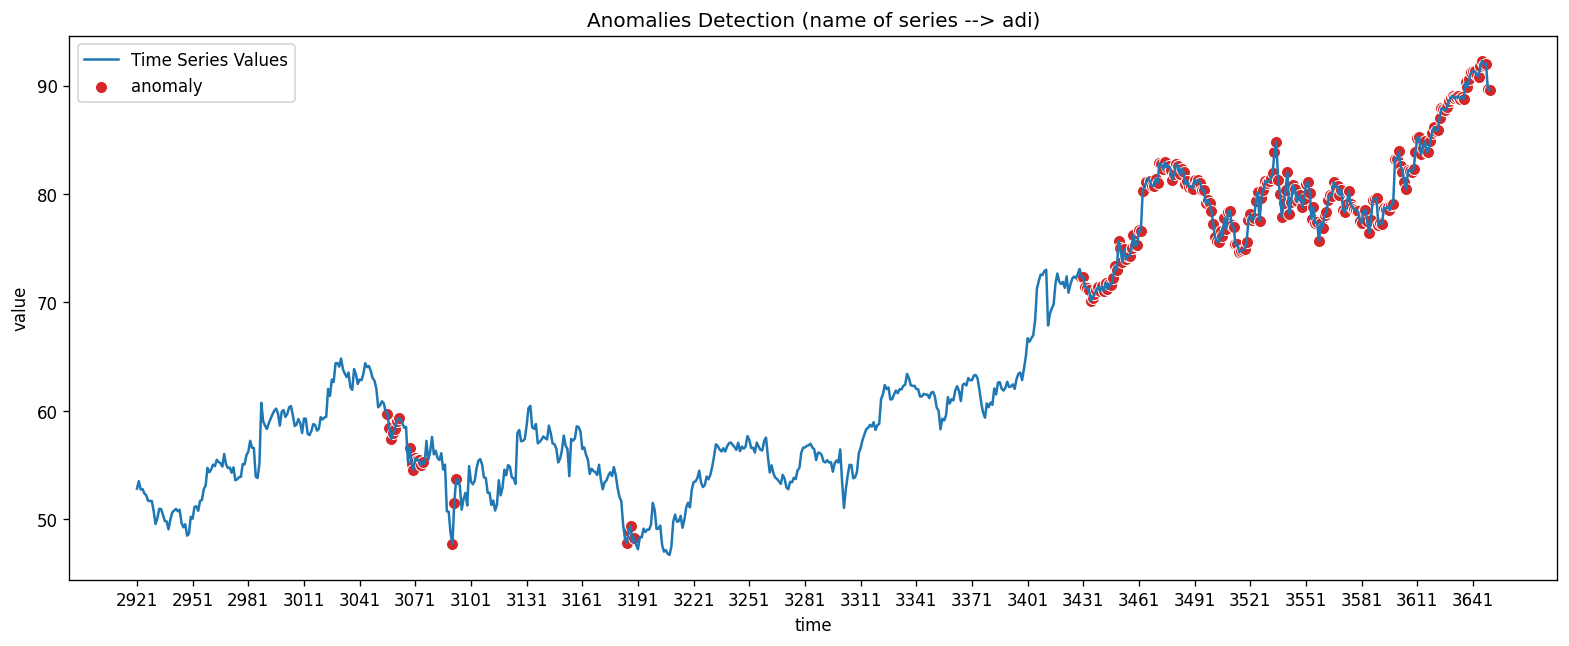

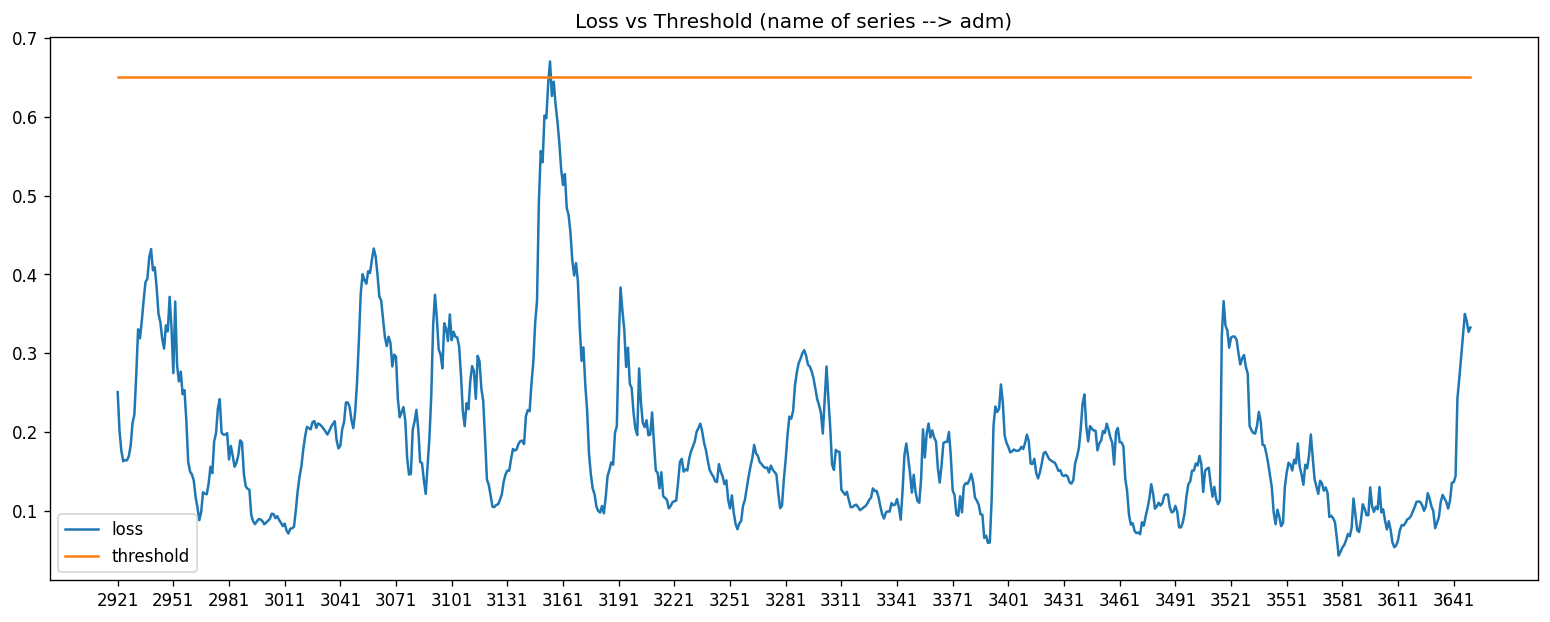

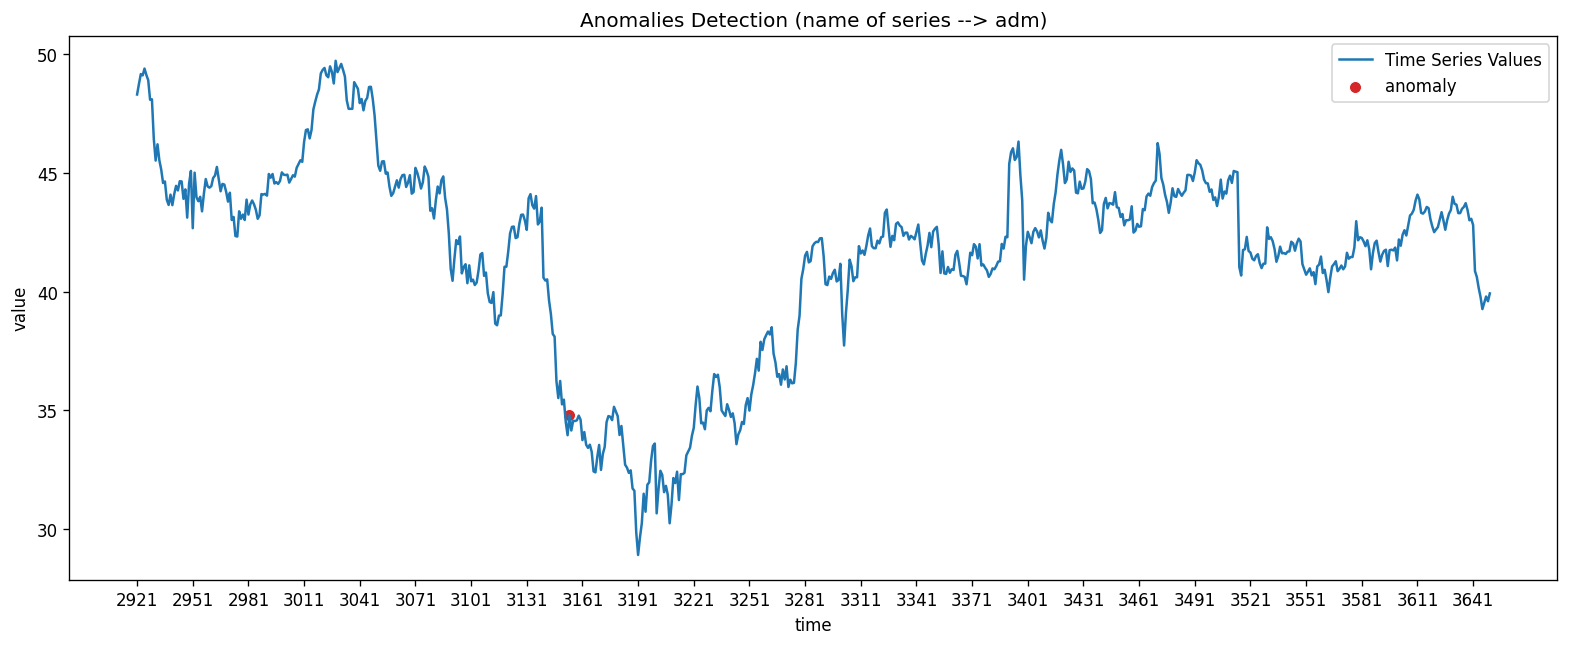

In [2]:
""" file : detect.py """

""" general imports """
#import argparse     # for command line argument parsing
#import sys
#import string

""" imports for dataframes, numpy """
#import pandas as pd
#import numpy as np
#import math

""" import functions from detect_utils.py """
#from detect_utils import execute

# main functionality

# parse command line input
#parser = argparse.ArgumentParser()
#parser.add_argument('-d', help="Specify input dataset file path", type=str, required=True)
#parser.add_argument('-n', help="Specify index of time series to forecast", type=int, required=True)
#parser.add_argument('-mae', help="Specify mean absolute error threshold", type=float, required=True)
#parser.add_argument('-load', help="Specify use of pre-trained models", dest='load', action='store_true', required=False)
#parser.add_argument('-train', help="Specify training of models", dest='load', action='store_false', required=False)
#parser.set_defaults(load=True)
#args = parser.parse_args()

#if args.n < 1:
#    sys.exit("Invalid time series index. Index should be positive integer\n")

# save arguments
dataset_path = './content/data/nasdaq2007_17.csv'
num_of_series = 10
threshold = 0.65
# load pre trained model or train new model
load_trained_model = True

# Load and peek the input dataset csv file
dataset = pd.read_csv(dataset_path, sep='\t', lineterminator='\n', header=None)

# keep names of time series in seperate dataframe and convert it to an array
series_names = pd.DataFrame(dataset, columns=[dataset.columns[0]]).values

# specify columns to keep (all but the first one)
cols = [False]
rest_cols= [True for x in range(dataset.shape[1]-1)]
cols.extend(rest_cols)

# set window
w = 30

# train one model over all series of dataset

# convert entire input dataset for all time series to array of series values
series_values = dataset.iloc[:, cols].values

# get transpose to have columns as different time series and rows as time series values at specific time points
series_values = series_values.T

# execute training or load pre trained model, make plots for first num_of_series series
execute(series_values, series_names, w, num_of_series, threshold, load_trained_model)
